### Thursday, May 11th, 2023

This code runs the main GDN program and initializes a model with stored weights.

In [1]:
import os, sys

In [2]:
sys.path = [
    '', 
    '/home/callistb/miniconda3/envs/gdn/lib/python38.zip', 
    '/home/callistb/miniconda3/envs/gdn/lib/python3.8', 
    '/home/callistb/miniconda3/envs/gdn/lib/python3.8/lib-dynload', 
    '/home/callistb/miniconda3/envs/gdn/lib/python3.8/site-packages'
]

In [3]:
os.chdir('/home/callistb/GDN')

In [4]:
from main import *

In [5]:
random_seed = 5

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
os.environ['PYTHONHASHSEED'] = str(random_seed)


train_config = {
    'batch': 32,
    'epoch': 50,
    'slide_win': 5,
    'dim': 128,
    'slide_stride': 1,
    'comment': '',
    'seed': random_seed,
    'out_layer_num': 1,
    'out_layer_inter_dim': 128,
    'decay': 0,
    'val_ratio': 0.2,
    'topk': 30,
}

env_config={
    'save_path': 'wadi',
    'dataset': 'wadi',
    'report': 'val',
    'device': 'cuda',
    'load_model_path': 'pretrained/wadi/best_05|04-15:46:47.pt'
}


main = Main(train_config, env_config, debug=False)
main.run()

=========================** Result **============================

F1 score: 0.40275650842266464
precision: 0.8885135135135135
recall: 0.2603960396039604



In [6]:
main.model

GDN(
  (embedding): Embedding(127, 128)
  (bn_outlayer_in): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gnn_layers): ModuleList(
    (0): GNNLayer(
      (gnn): GraphLayer(5, 128, heads=1)
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (leaky_relu): LeakyReLU(negative_slope=0.01)
    )
  )
  (out_layer): OutLayer(
    (mlp): ModuleList(
      (0): Linear(in_features=128, out_features=1, bias=True)
    )
  )
  (dp): Dropout(p=0.2, inplace=False)
)

Below we'll use their code to retrieve the predicted labels for the test set:

In [7]:
# compute smoothed error scores for test and validation sets (from main.py/get_score)
test_scores, normal_scores = get_full_err_scores(main.test_result, main.val_result)

In [8]:
# get top 1 per-channel score at each time step (from evaluate.py/get_val_performance_data)
topk=1
n_features, n_timesteps = test_scores.shape
topk_indices = np.argpartition(test_scores, range(n_features-topk-1, n_features), axis=0)[-topk:]
total_topk_err_scores = np.sum(np.take_along_axis(test_scores, topk_indices, axis=0), axis=0)

# threshold is the max error value of the validation set
threshold = normal_scores.max()
pred_labels = total_topk_err_scores > normal_scores.max()

In [9]:
# get ground truth labels
_, _, test_labels = main.test_result
test_labels = np.array(test_labels, dtype=int)[:,0]

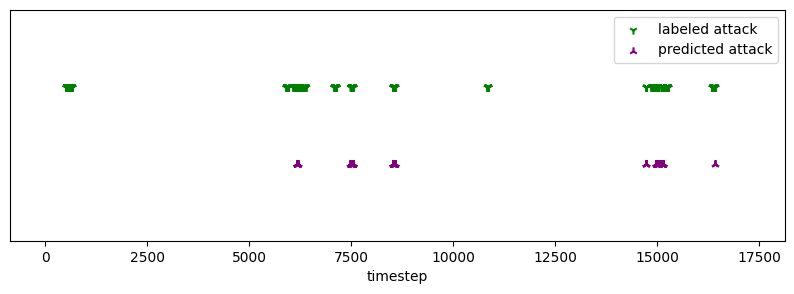

In [10]:
plt.figure(figsize=(10,3))

x = np.arange(n_timesteps)

# plot timesteps of labeled attacks
plt.scatter(x, test_labels+0.1, color='green', label='labeled attack', marker='1')

# plot timesteps of predicted attacks
plt.scatter(x, pred_labels, color='purple', label='predicted attack', marker='2')

plt.legend()
plt.ylim(0.90, 1.20)
plt.yticks(())
plt.xlabel("timestep")
plt.show()

Next we'll dive deeper into one of these attacks and try to see how the attention graph changes during the course of the attack. Let's first get the attention weights of the samples in the validation set:

In [94]:
val_atts = []
for x, _, _, ei0 in main.val_dataloader:
    pred = main.model(x.float().cuda(), ei0.cuda())
    
    att = main.model.gnn_layers[0].att_weight_1.detach().cpu().flatten()
    
    val_atts.append(att.reshape(len(x), -1))
    
val_atts = torch.cat(val_atts, 0)

This code gets the start and end timestamps of the attack that starts around the middle of the plot above:

In [95]:
sample_start = 8000
sample_end = 9000

# indices of attacks in timestap range [sample_start, sample_end)
attack_indices = np.where(test_labels[sample_start:sample_end])[0] + sample_start
attack_start = attack_indices.min()
attack_end = attack_indices.max()

print(f"attack start: {attack_start}, attack end: {attack_end}")

attack start: 8515, attack end: 8573


In [96]:
# let's put a little padding around the start and end
attack_start -= 30
attack_end += 30
attack_len = attack_end-attack_start

main.test_dataset[attack_start:attack_end][2]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)

In [97]:
# graph processing
import networkx as nx
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data

# image processing
from PIL import Image
import io
import IPython.display as disp

In [158]:
# get the graph and attention weights for each timestep in the attack
Gs = []
errs = []
atts = []
for i in range(attack_len):

    x   = main.test_dataset[attack_start+i][0].unsqueeze(0).float().cuda()
    ei0 = main.test_dataset.edge_index.cuda()

    pred = main.model(x, ei0)
    
    ei  = main.model.gnn_layers[0].edge_index_1.detach().cpu()
    att = main.model.gnn_layers[0].att_weight_1.detach().cpu().flatten()
    
    err = torch.Tensor(test_scores[:, attack_start+i].reshape(1, -1))
    
    Gs.append(to_networkx(Data(pred, ei), remove_self_loops=True))
    atts.append(att.reshape(1, -1))
    errs.append(err)
    
atts = torch.cat(atts, 0)
errs = torch.cat(errs, 0)

In [238]:
images = []
for i in range(attack_len):
    if (i % (attack_len//10) == 0):
        print(i)
    
    fig, ax = plt.subplots(1,1,figsize=(7,7))
    
    nx.draw_networkx(
        Gs[i],
        pos=nx.spectral_layout(Gs[i]),
        ax=ax,
        
        arrows=False,
        with_labels=False,
        
        # the edge width is the deviation from the validation weights during the attack
        # (to highlight important edges)
        width=(atts.std(0) - val_atts.std(0)).abs(),
        
        # the edge color is the squared value of the attention weight
        edge_color=plt.cm.Greys(atts[i].square()),
        
        # the node color is the error score
        node_color=plt.cm.plasma(errs[i]),
        
        node_size=np.minimum(errs[i].square()*50, 50),
    )
    plt.title(f"timestep {i}")

    with io.BytesIO() as buf:
        plt.savefig(buf)
        image = Image.open(buf)
        image.load()
        images.append(image)

    plt.close()

0
11
22
33
44
55
66
77
88
99
110


In [241]:
images[0].save('/tmp/graphs.gif', save_all=True, append_images=images[1:], loop=0)

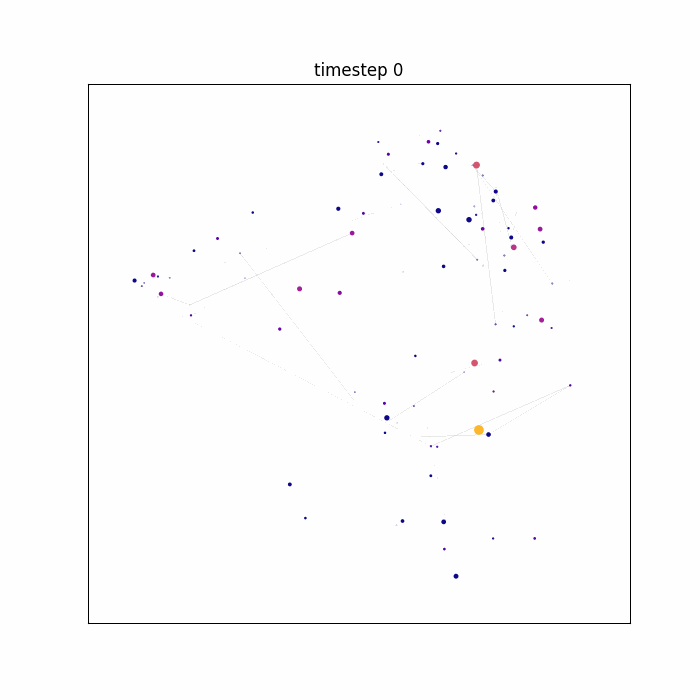

In [242]:
disp.Image("/tmp/graphs.gif")